In [4]:
import matplotlib.pyplot as plt
from matplotlib import tri
import matplotlib.tri as mtri
import numpy as np
import meshio

In [5]:
# leitura da malha no GMSH
msh = meshio.read('malhas/quadrado.msh') 
X = msh.points[:,0]
Y = msh.points[:,1]
IEN = msh.cells[1].data
IENbound = msh.cells[0].data
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1) 
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem] 
npoints = len(X)
ne = IEN.shape[0]

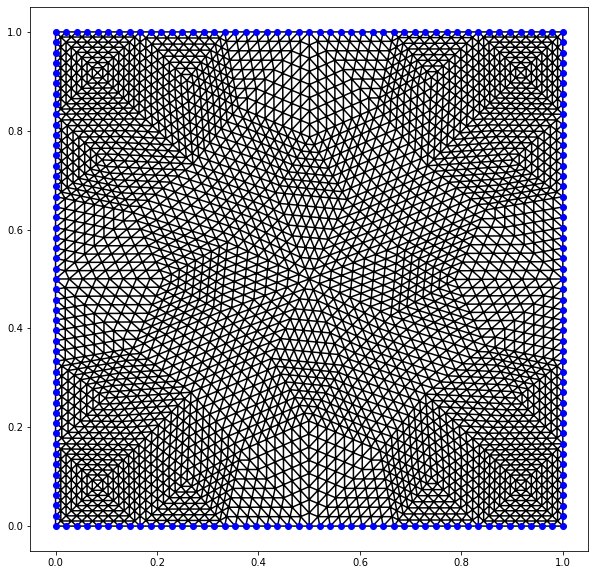

In [6]:
# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size)) 
ccName = [[] for i in range( len(X) )]
for elem in range(0,len(IENbound)):
 ccName[ IENbound[elem][0] ] = IENboundElem[elem] 
 ccName[ IENbound[elem][1] ] = IENboundElem[elem]

#--------------------------------------------------
# plot malha e pontos de contorno 
plt.figure(figsize=(10, 10))
plt.triplot(X,Y,IEN,'k-') 
plt.plot(X[cc],Y[cc],'bo') 
plt.show()
#-------------------------------------------------- 

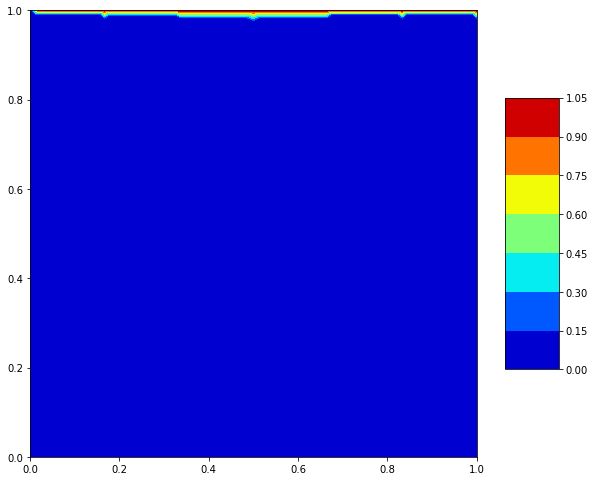

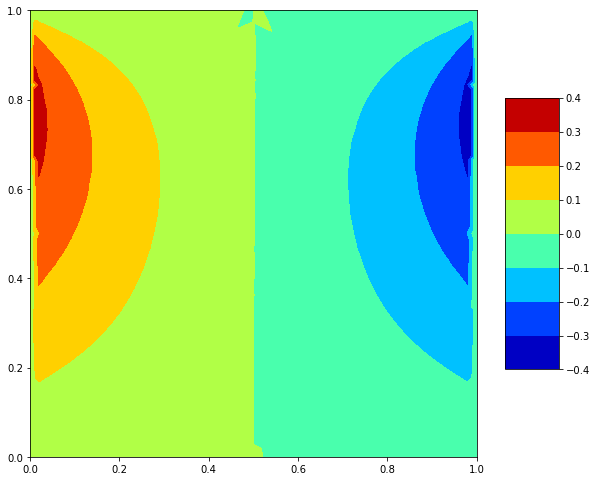

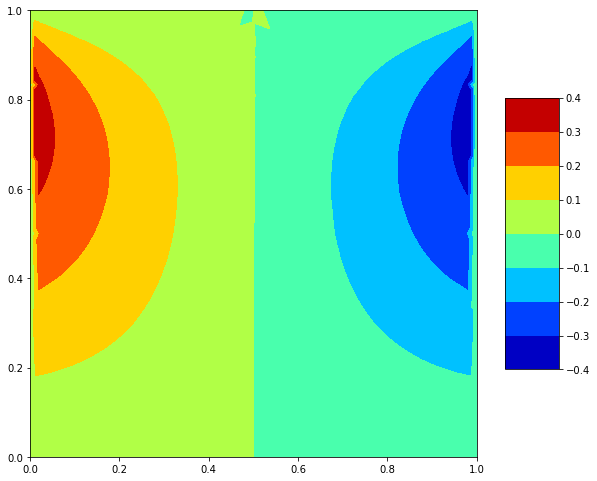

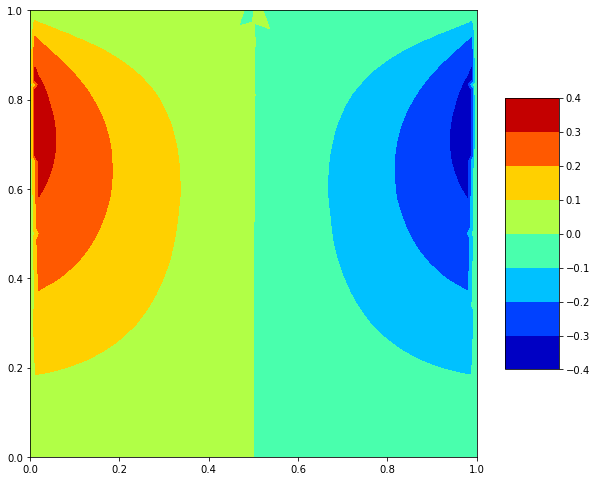

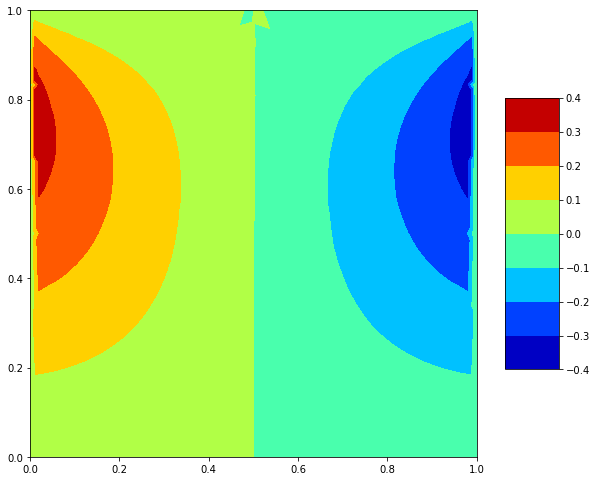

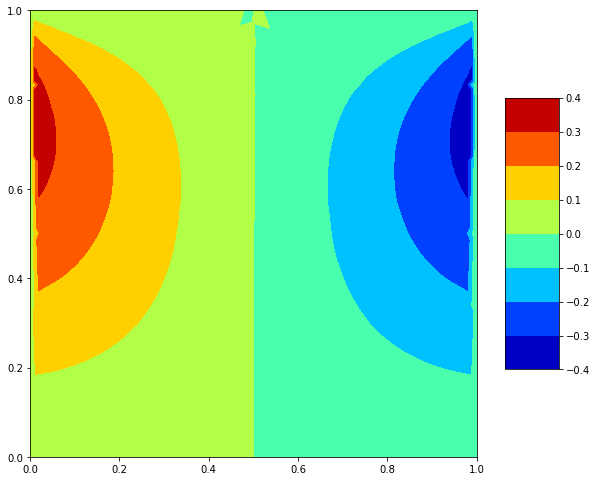

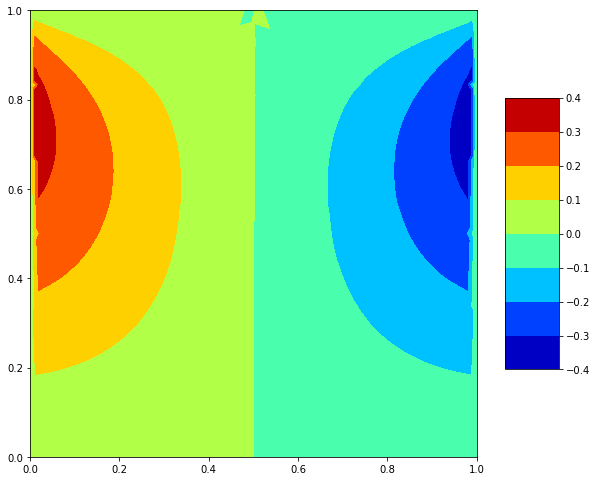

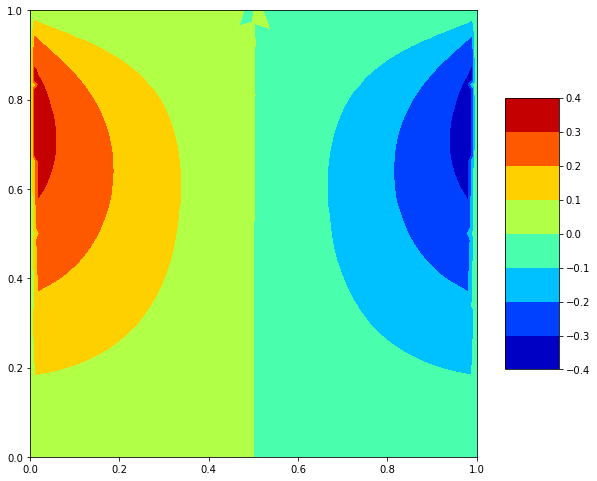

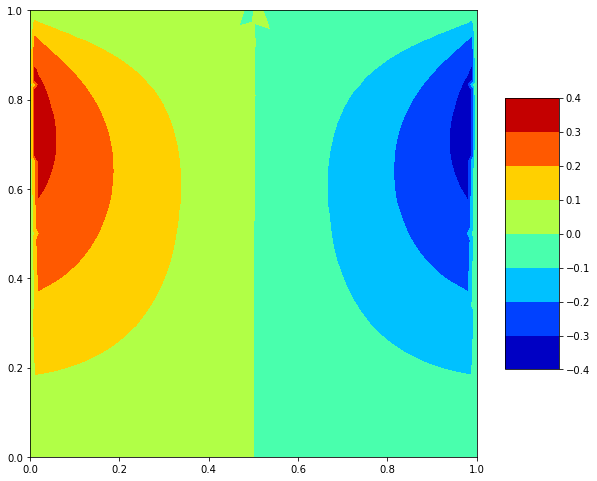

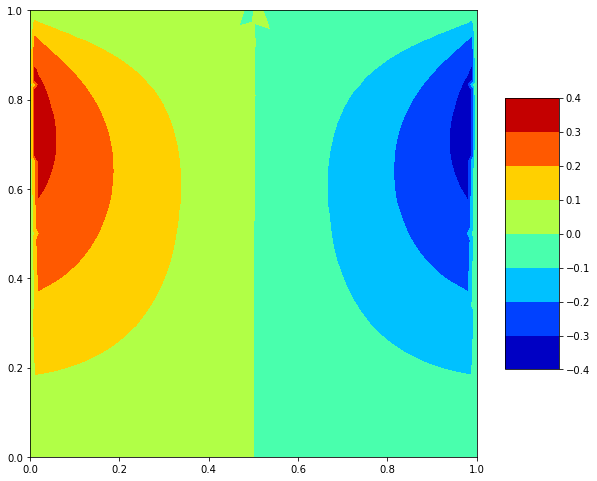

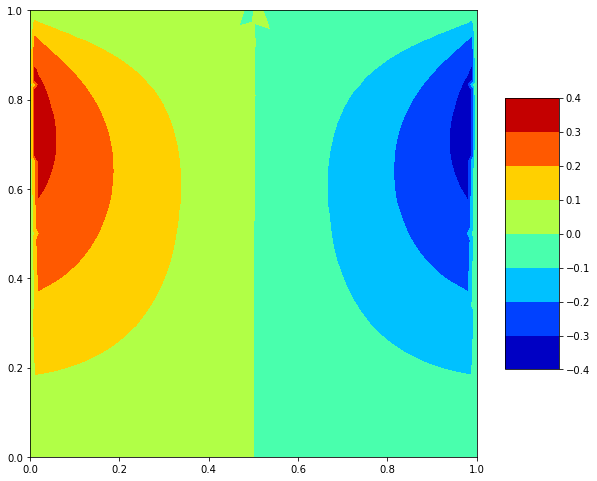

In [10]:
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )
G = np.zeros( (npoints,npoints),dtype='float' )
I = np.identity( (npoints),dtype='float' )
b = np.zeros( (npoints),dtype='float' )
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
Wz = np.zeros( (npoints),dtype='float' )
dt = 0.1
nIter = 10

for e in range(0,ne):
 # definicao das matrizes do elemento
 v1 = IEN[e,0]
 v2 = IEN[e,1]
 v3 = IEN[e,2]

 bi = Y[v2] - Y[v3]
 bj = Y[v3] - Y[v1]
 bk = Y[v1] - Y[v2]
 ci = X[v3] - X[v2]
 cj = X[v1] - X[v3]
 ck = X[v2] - X[v1]

 area = (1.0/2.0)*np.linalg.det( [[1,X[v1],Y[v1]],
                                  [1,X[v2],Y[v2]],
                                  [1,X[v3],Y[v3]] ] )
 kxele = (1.0/(4*area))*np.array( [[bi*bi,bi*bj,bi*bk],
                                   [bj*bi,bj*bj,bj*bk],
                                   [bk*bi,bk*bj,bk*bk]])
 kyele = (1.0/(4*area))*np.array( [[ci*ci,ci*cj,ci*ck],
                                   [cj*ci,cj*cj,cj*ck],
                                   [ck*ci,ck*cj,ck*ck]])
 gxele = (1.0/6.0)*np.array( [[bi,bj,bk],
                              [bi,bj,bk],
                              [bi,bj,bk]])
 gyele = (1.0/6.0)*np.array( [[ci,cj,ck],
                              [ci,cj,ck],
                              [ci,cj,ck]])

 massele = (area/12.0) * np.array([ [2.0, 1.0, 1.0],
                                    [1.0, 2.0, 1.0],
                                    [1.0, 1.0, 2.0] ])

 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal]  += kxele[ilocal,jlocal] + kyele[ilocal,jlocal]
   M[iglobal,jglobal]  += massele[ilocal,jlocal] 
   Gx[iglobal,jglobal] += gxele[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyele[ilocal,jlocal]

# Matrizes do Divergente
Dx = Gx.transpose()
Dy = Gy.transpose()

# condicoes de contorno de Dirichlet
for i in cc:
  if ccName[i] == 'inlet' or ccName[i] == 'outlet':
    vx[i] = 0; vy[i] = 0

  if ccName[i] == 'paredeInf':
    vx[i] = 0; vy[i] = 0

  if ccName[i] == 'paredeSup':
    vx[i] = 1; vy[i] = 0
  
# plot dos resultados
triang = mtri.Triangulation(X,Y,IEN)
plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.set_aspect('equal')
#ax.triplot(triang,'ko-') 
surf = ax.tricontourf(triang,vx,cmap='jet')
plt.colorbar(surf,shrink=0.5, aspect=5)
#plt.triplot(X,Y,IEN,'k-') 
#plt.plot(X[cc],Y[cc],'bo') 
plt.show()

#Inicialização do campo de vorticidade
Wz = np.linalg.solve(M, (Gx@vy - Gy@vx))

for n in range(0,nIter):

  Wz = np.linalg.solve(M, (Gx@vy - Gy@vx))

  A_wz = M/dt + K #+ (vx@Dx + vy@Dy)
  b_wz = (M/dt)@Wz
  # condicoes de contorno de Dirichlet

  Wz = np.linalg.solve(A_wz,b_wz)

  A_psi = K.copy()
  b_psi = M@Wz
  # condicoes de contorno de Dirichlet
  for i in cc:
    A_psi[i,:] = 0.0; A_psi[i,i] = 1.0
    if ccName[i] == 'inlet' or ccName[i] == 'outlet':
      b_psi[i] = 0.0
    if ccName[i] == 'paredeInf':
      b_psi[i] = 0.0
    if ccName[i] == 'paredeSup':
      b_psi[i] = 0.0
    if ccName[i] == 'objeto':
      b_psi[i] = 0.0
  # solucao da funcao corrente
  psi = np.linalg.solve(A_psi,b_psi)

  # recuperar as velocidades
  vx =  np.linalg.solve(M, (Gy@psi) )
  vy = -np.linalg.solve(M, (Gx@psi) )

  for i in cc:
    if ccName[i] == 'inlet' or ccName[i] == 'outlet':
      vx[i] = 0; vy[i] = 0

    if ccName[i] == 'paredeInf':
      vx[i] = 0; vy[i] = 0

    if ccName[i] == 'paredeSup':
      vx[i] = 1; vy[i] = 0

  # plot dos resultados
  triang = mtri.Triangulation(X,Y,IEN)
  plt.figure(figsize=(10, 10))
  ax = plt.axes()
  ax.set_aspect('equal')
  #ax.triplot(triang,'ko-') 
  surf = ax.tricontourf(triang,vy,cmap='jet')
  plt.colorbar(surf,shrink=0.5, aspect=5)
  #plt.triplot(X,Y,IEN,'k-') 
  #plt.plot(X[cc],Y[cc],'bo') 
  plt.show()

In [8]:
# grava solucao em VTK para usar no PARAVIEW
mpoints = np.stack( (X,Y,X*0),axis=1 )
mIEN = {'triangle' : IEN}
point_data = {'VelocidadeX': vx,
              'VelocidadeY': vy,
              'Linha_de_Correte': psi,
              'Vorticidade': Wz
             }
meshio.write_points_cells('solucao_' + 'vx' + '.vtk',
                        cells=mIEN,
                        points=mpoints,
                        #file_format="vtk-ascii",
                        point_data=point_data,
                        )